# environmental setup

In [1]:
# BASIC
import numpy as np
import xarray as xr
import pandas as pd

#xr.set_options(display_style="text") # make it look better when posted online. Comment to get nicer representation of xarrays
import os

# matplotlib
import matplotlib
#%matplotlib inline
import matplotlib as mpl
import matplotlib.pylab as plt
import matplotlib.tri as mtri
import matplotlib.dates as md
import matplotlib.patches as patches
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from matplotlib import ticker
matplotlib.rcParams['figure.dpi'] = 300
matplotlib.rcParams['axes.linewidth'] = 1.5

## color
from matplotlib import cm
import cmocean
import seaborn as sns

## cartopy
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point


# scipy
from scipy import stats
from scipy import optimize
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
from scipy.stats import binned_statistic
import scipy.spatial.qhull as qhull


# metpy
import metpy
import metpy.calc as mpcalc


# etc
import subprocess
import time
import datetime
from datetime import timedelta
import calendar


# Dask
import dask # Distributed data libary
from dask import delayed
from dask import compute
from dask_jobqueue import SLURMCluster # Setting up distributed memories via slurm
from dask.utils import format_bytes
from distributed import Client, progress # Libaray to orchestrate distributed resources
from dask.distributed import Client
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})

from pathlib import Path
from getpass import getuser # Libaray to copy things
from pathlib import Path # Object oriented libary to deal with paths
from tempfile import NamedTemporaryFile, TemporaryDirectory # Creating temporary Files/Dirs
import warnings
warnings.filterwarnings(action='ignore')



In [2]:
WORK_DIR = '~/python/land_atm_coupling/land-atm_coupling_publication/'

# data

In [3]:
dpath = f'{WORK_DIR}/data/CMIP6/'
land_frac = xr.open_mfdataset(f'{dpath}/bc_land_frac_2x2.nc')
land_frac

<xarray.Dataset>
Dimensions:        (lon: 180, lat: 90)
Coordinates:
  * lon            (lon) float64 -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
  * lat            (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
Data variables: (12/21)
    notsea         (lat, lon) float64 dask.array<chunksize=(90, 180), meta=np.ndarray>
    fract_glac     (lat, lon) float64 dask.array<chunksize=(90, 180), meta=np.ndarray>
    sea            (lat, lon) float64 dask.array<chunksize=(90, 180), meta=np.ndarray>
    fract_lake     (lat, lon) float64 dask.array<chunksize=(90, 180), meta=np.ndarray>
    fract_land     (lat, lon) float64 dask.array<chunksize=(90, 180), meta=np.ndarray>
    fract_veg      (lat, lon) float64 dask.array<chunksize=(90, 180), meta=np.ndarray>
    ...             ...
    fract_pft09    (lat, lon) float64 dask.array<chunksize=(90, 180), meta=np.ndarray>
    fract_pft10    (lat, lon) float64 dask.array<chunksize=(90, 180), meta=np.ndarray>
    fract_pft11    (lat, lon) float64 dask.array<chunksize=(90, 180), meta=np.ndarray>
    land           (lat, lon) float64 dask.array<chunksize=(90, 180), meta=np.ndarray>
    lake           (lat, lon) float64 dask.array<chunksize=(90, 180), meta=np.ndarray>
    glac           (lat, lon) float64 dask.array<chunksize=(90, 180), meta=np.ndarray>
Attributes: (12/44)
    CDI:                      Climate Data Interface version 2.0.6 (https://m...
    Conventions:              CF-1.6
    institution:              Max Planck Institute for Meteorology
    title:                    ICON grid description
    revision:                 Unknown
    date:                     20190730 at 185620
    ...                       ...
    subcentre:                1
    ICON_grid_file_uri:       http://icon-downloads.mpimet.mpg.de/grids/publi...
    comment:                  setup for an experiment with ocean model: grid ...
    history:                  Fri Oct 21 15:40:01 2022: cdo remap,grid_2x2.tx...
    NCO:                      4.6.7
    CDO:                      Climate Data Operators version 2.0.6 (https://m...

## ICON

In [4]:
dpath = f'{WORK_DIR}/data/dpp0066/'

dataICON1  = xr.open_mfdataset(f'{dpath}/dpp0066_2020_full_daily_pr_2x2.nc')
dataICON2  = xr.open_mfdataset(f'{dpath}/dpp0066_2020_full_daily_hfls_2x2.nc')
dataICON3  = xr.open_mfdataset(f'{dpath}/dpp0066_2020_full_daily_hfss_2x2.nc')
dataICON4  = xr.open_mfdataset(f'{dpath}/dpp0066_2020_full_daily_run_2x2.nc')
dataICON5  = xr.open_mfdataset(f'{dpath}/dpp0066_2020_full_daily_rootsm_2x2.nc')
dataICON51 = xr.open_mfdataset(f'{dpath}/dpp0066_2020_full_daily_rsds_2x2.nc')
dataICON52 = xr.open_mfdataset(f'{dpath}/dpp0066_2020_full_daily_rsus_2x2.nc')
dataICON53 = xr.open_mfdataset(f'{dpath}/dpp0066_2020_full_daily_rlds_2x2.nc')
dataICON54 = xr.open_mfdataset(f'{dpath}/dpp0066_2020_full_daily_rlus_2x2.nc')
dataICON6  = xr.open_mfdataset(f'{dpath}/dpp0066_2020_full_daily_drain_2x2.nc')
dataICON7  = xr.open_mfdataset(f'{dpath}/dpp0066_2020_full_daily_smi_2x2.nc')
dataICON8  = xr.open_mfdataset(f'{dpath}/dpp0066_2020_full_daily_w_soil_sl0_2x2.nc')


dataICON = xr.merge([dataICON1, dataICON2, dataICON3, dataICON4, dataICON5, 
                     dataICON51, dataICON52, dataICON53, dataICON54, 
                     dataICON6, dataICON7, dataICON8,])

dataICON1= dataICON
dataICON = dataICON.sel(time=slice('2020-06-01','2020-08-31'))
dataICON

<xarray.Dataset>
Dimensions:              (time: 92, lon: 180, lat: 90)
Coordinates:
  * time                 (time) datetime64[ns] 2020-06-01 ... 2020-08-31
  * lon                  (lon) float64 -179.0 -177.0 -175.0 ... 177.0 179.0
  * lat                  (lat) float64 -89.0 -87.0 -85.0 ... 85.0 87.0 89.0
Data variables: (12/13)
    pr                   (time, lat, lon) float32 dask.array<chunksize=(92, 90, 180), meta=np.ndarray>
    hfls                 (time, lat, lon) float32 dask.array<chunksize=(92, 90, 180), meta=np.ndarray>
    hfss                 (time, lat, lon) float32 dask.array<chunksize=(92, 90, 180), meta=np.ndarray>
    run                  (time, lat, lon) float32 dask.array<chunksize=(92, 90, 180), meta=np.ndarray>
    rootsm               (time, lat, lon) float32 dask.array<chunksize=(92, 90, 180), meta=np.ndarray>
    rsds                 (time, lat, lon) float32 dask.array<chunksize=(92, 90, 180), meta=np.ndarray>
    ...                   ...
    rlds                 (time, lat, lon) float32 dask.array<chunksize=(92, 90, 180), meta=np.ndarray>
    rlus                 (time, lat, lon) float32 dask.array<chunksize=(92, 90, 180), meta=np.ndarray>
    drain                (time, lat, lon) float32 dask.array<chunksize=(92, 90, 180), meta=np.ndarray>
    smi                  (time, lat, lon) float64 dask.array<chunksize=(92, 90, 180), meta=np.ndarray>
    hydro_w_soil_sl_box  (time, lat, lon) float32 dask.array<chunksize=(92, 90, 180), meta=np.ndarray>
    hydro_w_ice_sl_box   (time, lat, lon) float32 dask.array<chunksize=(92, 90, 180), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.3 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Mon Nov 28 14:33:25 2022: cdo remap,/work/mh0731/m300793/da...
    CDO:          Climate Data Operators version 2.0.3 (https://mpimet.mpg.de...

In [5]:
dpath = f'{WORK_DIR}/data/dpp0066/'
dataICON_init = xr.open_mfdataset(f'{dpath}/bc_land_soil_2x2.nc')

## CMIP

In [6]:
dpath     = f'{WORK_DIR}/data/CMIP6/'

dataCMIP1  = xr.open_mfdataset(dpath+'/ICON-ESM-LR_full_daily_pr_2x2.nc')
dataCMIP2  = xr.open_mfdataset(dpath+'/ICON-ESM-LR_full_daily_hfls_2x2.nc')
dataCMIP3  = xr.open_mfdataset(dpath+'/ICON-ESM-LR_full_daily_hfss_2x2.nc')
dataCMIP4  = xr.open_mfdataset(dpath+'/ICON-ESM-LR_full_daily_runoff_2x2.nc')
dataCMIP5  = xr.open_mfdataset(dpath+'/ICON-ESM-LR_full_daily_rzwc_2x2.nc')
dataCMIP51 = xr.open_mfdataset(dpath+'/ICON-ESM-LR_full_daily_rsds_2x2.nc')
dataCMIP52 = xr.open_mfdataset(dpath+'/ICON-ESM-LR_full_daily_rsus_2x2.nc')
dataCMIP53 = xr.open_mfdataset(dpath+'/ICON-ESM-LR_full_daily_rlds_2x2.nc')
dataCMIP54 = xr.open_mfdataset(dpath+'/ICON-ESM-LR_full_daily_rlus_2x2.nc')
dataCMIP6  = xr.open_mfdataset(dpath+'/ICON-ESM-LR_full_daily_drain_2x2.nc')
dataCMIP7  = xr.open_mfdataset(dpath+'/ICON-ESM-LR_full_daily_smi_2x2.nc')
dataCMIP8  = xr.open_mfdataset(dpath+'/ICON-ESM-LR_full_daily_w_soil_sl_2x2.nc').isel(soil_depth_water=0)

dataCMIP = xr.merge([dataCMIP1, dataCMIP2, dataCMIP3, dataCMIP4, dataCMIP5, 
                     dataCMIP51, dataCMIP52, dataCMIP53, dataCMIP54, 
                     dataCMIP6, dataCMIP7, dataCMIP8])
dataCMIP1 = dataCMIP
dataCMIP = dataCMIP.sel(time=dataCMIP.time.dt.month.isin([6, 7, 8]))
dataCMIP

<xarray.Dataset>
Dimensions:              (time: 5520, lon: 180, lat: 90)
Coordinates:
  * time                 (time) datetime64[ns] 2000-06-01 ... 2059-08-31
  * lon                  (lon) float64 -179.0 -177.0 -175.0 ... 177.0 179.0
  * lat                  (lat) float64 -89.0 -87.0 -85.0 ... 85.0 87.0 89.0
    soil_depth_water     float64 0.0325
Data variables: (12/13)
    pr                   (time, lat, lon) float32 dask.array<chunksize=(5520, 90, 180), meta=np.ndarray>
    hfls                 (time, lat, lon) float32 dask.array<chunksize=(5520, 90, 180), meta=np.ndarray>
    hfss                 (time, lat, lon) float32 dask.array<chunksize=(5520, 90, 180), meta=np.ndarray>
    mrro                 (time, lat, lon) float32 dask.array<chunksize=(5520, 90, 180), meta=np.ndarray>
    rzwc                 (time, lat, lon) float32 dask.array<chunksize=(5520, 90, 180), meta=np.ndarray>
    rsds                 (time, lat, lon) float32 dask.array<chunksize=(5520, 90, 180), meta=np.ndarray>
    ...                   ...
    rlds                 (time, lat, lon) float32 dask.array<chunksize=(5520, 90, 180), meta=np.ndarray>
    rlus                 (time, lat, lon) float32 dask.array<chunksize=(5520, 90, 180), meta=np.ndarray>
    hydro_drainage_box   (time, lat, lon) float32 dask.array<chunksize=(5520, 90, 180), meta=np.ndarray>
    smi                  (time, lat, lon) float64 dask.array<chunksize=(5520, 90, 180), meta=np.ndarray>
    hydro_w_soil_sl_box  (time, lat, lon) float32 dask.array<chunksize=(5520, 90, 180), meta=np.ndarray>
    hydro_w_ice_sl_box   (time, lat, lon) float32 dask.array<chunksize=(5520, 90, 180), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.6 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Fri Oct 21 15:15:30 2022: cdo remap,grid_2x2.txt,weight_2x2...
    CDO:          Climate Data Operators version 2.0.6 (https://mpimet.mpg.de...

In [7]:
dpath = f'{WORK_DIR}/data/CMIP6/'
dataCMIP_init = xr.open_mfdataset(dpath+'/bc_land_soil_2x2.nc')

# processing

In [8]:
icon_pr = dataICON['pr'].mean('time')

cmip_pr = dataCMIP['pr'].mean('time') * 86400.

In [9]:
icon_smi = xr.where( (cmip_pr>=.1)&(icon_pr>=.1)&(land_frac['fract_lake']<0.1), dataICON['smi'], np.NaN)
icon_y1  = xr.where( (cmip_pr>=.1)&(icon_pr>=.1)&(land_frac['fract_lake']<0.1), dataICON['hfls'], np.NaN)
icon_y2  = xr.where( (cmip_pr>=.1)&(icon_pr>=.1)&(land_frac['fract_lake']<0.1), dataICON['hfss'], np.NaN)

icon_corr_lh_pr      = xr.where((cmip_pr>=.1)&(icon_pr>=.1)&( land_frac['fract_lake'] < 0.1), 
                                xr.corr(dataICON['pr'], icon_y1, dim='time'), np.NaN) #.values
icon_corr_sh_pr      = xr.where((cmip_pr>=.1)&(icon_pr>=.1)&( land_frac['fract_lake'] < 0.1), 
                                xr.corr(dataICON['pr'], icon_y2, dim='time'), np.NaN) #.values

In [10]:

cmip_smi = xr.where( (icon_pr>=.1)&(cmip_pr>=.1)&( land_frac['fract_lake']<0.1), dataCMIP['smi'], np.NaN)
cmip_y1  = xr.where( (icon_pr>=.1)&(cmip_pr>=.1)&( land_frac['fract_lake']<0.1), dataCMIP['hfls'], np.NaN)
cmip_y2  = xr.where( (icon_pr>=.1)&(cmip_pr>=.1)&( land_frac['fract_lake']<0.1), dataCMIP['hfss'], np.NaN)

cmip_corr_lh_pr      = xr.where((icon_pr>=.1)&(cmip_pr>=.1)&( land_frac['fract_lake'] < 0.1), 
                                xr.corr(dataCMIP['pr']*86400., cmip_y1, dim='time'), np.NaN).values
cmip_corr_sh_pr      = xr.where((icon_pr>=.1)&(cmip_pr>=.1)&( land_frac['fract_lake'] < 0.1), 
                                xr.corr(dataCMIP['pr']*86400., cmip_y2, dim='time'), np.NaN).values

In [11]:
icon_corr_lh_smi  = xr.where((icon_pr>=.1)&(cmip_pr>=.1)&( land_frac['fract_lake'] < 0.1), 
                             xr.corr(dataICON['smi'], icon_y1, dim='time'), np.NaN) #.values
icon_corr_sh_smi  = xr.where((icon_pr>=.1)&(cmip_pr>=.1)&( land_frac['fract_lake'] < 0.1), 
                             xr.corr(dataICON['smi'], icon_y2, dim='time'), np.NaN).values
icon_corr_pr_smi  = xr.where((icon_pr>=.1)&(cmip_pr>=.1)&( land_frac['fract_lake'] < 0.1), 
                             xr.corr(dataICON['smi'], dataICON['pr'], dim='time'), np.NaN).values
icon_corr_pr_smi  = xr.where((icon_pr>=.1)&(cmip_pr>=.1)&( land_frac['fract_lake'] < 0.1), 
                             xr.corr(dataICON['smi'], dataICON['pr'], dim='time'), np.NaN) #.values
icon_corr_lh_sl0  = xr.where((icon_pr>=.1)&(cmip_pr>=.1)&( land_frac['fract_lake'] < 0.1), 
                             xr.corr(dataICON['hydro_w_soil_sl_box'], icon_y1, dim='time'), np.NaN) #.values
icon_corr_pr_sl0  = xr.where((icon_pr>=.1)&(cmip_pr>=.1)&( land_frac['fract_lake'] < 0.1), 
                             xr.corr(dataICON['hydro_w_soil_sl_box'], dataICON['pr'], dim='time'), np.NaN)#.values

cmip_corr_lh_smi  = xr.where((cmip_pr>=.1)&(icon_pr>=.1)&( land_frac['fract_lake'] < 0.1), 
                             xr.corr(dataCMIP['smi'], cmip_y1, dim='time'), np.NaN).values
cmip_corr_sh_smi  = xr.where((cmip_pr>=.1)&(icon_pr>=.1)&( land_frac['fract_lake'] < 0.1), 
                             xr.corr(dataCMIP['smi'], cmip_y2, dim='time'), np.NaN).values
cmip_corr_pr_smi  = xr.where((cmip_pr>=.1)&(icon_pr>=.1)&( land_frac['fract_lake'] < 0.1), 
                             xr.corr(dataCMIP['smi'], dataCMIP['pr']*86400., dim='time'), np.NaN).values
cmip_corr_lh_sl0  = xr.where((cmip_pr>=.1)&(icon_pr>=.1)&( land_frac['fract_lake'] < 0.1), 
                             xr.corr(dataCMIP['hydro_w_soil_sl_box'], cmip_y1, dim='time'), np.NaN).values
cmip_corr_pr_sl0  = xr.where((cmip_pr>=.1)&(icon_pr>=.1)&( land_frac['fract_lake'] < 0.1), 
                             xr.corr(dataCMIP['hydro_w_soil_sl_box'], dataCMIP['pr']*86400., dim='time'), np.NaN).values


In [12]:
CMIP_lon, CMIP_lat = np.meshgrid(dataICON['lon'], dataICON['lat'])

### internal variability

In [13]:
temp_pr_smi = []
temp_lh_smi = []
temp_sh_smi = []
temp_lh_pr  = []
temp_rad_lh  = []
temp_rad_pr  = []

for tt in np.arange(2000,2060):
    pr  = dataCMIP['pr'].sel(time=str(tt))*86400.
    smi = dataCMIP['smi'].sel(time=str(tt))
    lh  = cmip_y1.sel(time=str(tt))
    sh  = cmip_y2.sel(time=str(tt))

    corr_temp = xr.where((cmip_pr>=.1)&(icon_pr>=.1)&(land_frac['fract_lake']<0.1), 
                                xr.corr(pr, smi, dim='time'), np.NaN)
    temp_pr_smi.append(corr_temp)
    
    corr_temp = xr.where((cmip_pr>=.1)&(icon_pr>=.1)&(land_frac['fract_lake']<0.1), 
                                xr.corr(lh, smi, dim='time'), np.NaN)
    temp_lh_smi.append(corr_temp)

    corr_temp = xr.where((cmip_pr>=.1)&(icon_pr>=.1)&(land_frac['fract_lake']<0.1), 
                                xr.corr(sh, smi, dim='time'), np.NaN)
    temp_sh_smi.append(corr_temp)

    corr_temp = xr.where((cmip_pr>=.1)&(icon_pr>=.1)&(land_frac['fract_lake']<0.1), 
                                xr.corr(lh, pr, dim='time'), np.NaN)
    temp_lh_pr.append(corr_temp)

In [14]:
internal_pr_smi = xr.concat(temp_pr_smi,dim='time')
internal_pr_smi['time'] =  pd.date_range('2000-06-01', periods=60, freq='1Y')

internal_lh_smi = xr.concat(temp_lh_smi,dim='time')
internal_lh_smi['time'] =  pd.date_range('2000-06-01', periods=60, freq='1Y')

internal_sh_smi = xr.concat(temp_sh_smi,dim='time')
internal_sh_smi['time'] =  pd.date_range('2000-06-01', periods=60, freq='1Y')

internal_lh_pr = xr.concat(temp_lh_pr,dim='time')
internal_lh_pr['time'] =  pd.date_range('2000-06-01', periods=60, freq='1Y')

In [15]:
qt = (0, 0.05, 0.5, 0.95, 1.0)
qt_pr_smi  = internal_pr_smi.chunk(dict(time=-1)).quantile(qt, dim='time').values
std_pr_smi = internal_pr_smi.chunk(dict(time=-1)).std(dim='time').values

In [16]:
scale = 1.
lower_pr_smi = cmip_corr_pr_smi-std_pr_smi*scale
lower_pr_smi = np.where(qt_pr_smi[0,:]>lower_pr_smi,qt_pr_smi[0,:],lower_pr_smi)
upper_pr_smi = cmip_corr_pr_smi+std_pr_smi*scale
upper_pr_smi = np.where(qt_pr_smi[4,:]<upper_pr_smi,qt_pr_smi[4,:],upper_pr_smi)

In [17]:
icon_plot = icon_corr_pr_smi
cmip_plot = cmip_corr_pr_smi
lower, upper = lower_pr_smi, upper_pr_smi

box_xr = cmip_plot * 0.
box_xr = np.where( (lower>=icon_plot)|(upper<=icon_plot), 1, np.NaN)
box_fin = box_xr

In [18]:
box_xr

make_nc = xr.Dataset(
    {
        "box_xr" : (("lat", "lon"), box_xr,),
    },
    coords={
            "lat": dataICON['lat'].values, "lon": dataICON['lon'].values, 
           },
)

# make_nc.to_netcdf(f'{WORK_DIR}/data/dpp0066/box_pr-smi_one_sigma.nc', mode='w')

### masking field

In [19]:
dpath = f'{WORK_DIR}/data/dpp0066/'
box_pr_smi = xr.open_mfdataset(dpath+'/box_pr-smi_one_sigma.nc')
box_fin = box_pr_smi['box_xr']
box_xr = box_fin

# plot

In [20]:
box = [-180,180,-60,90]

cmap=cm.get_cmap('RdBu', 20)
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap_d = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

cmap=cm.get_cmap('viridis_r', 10)
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N+1)

# Figure 1. Combination of Corr

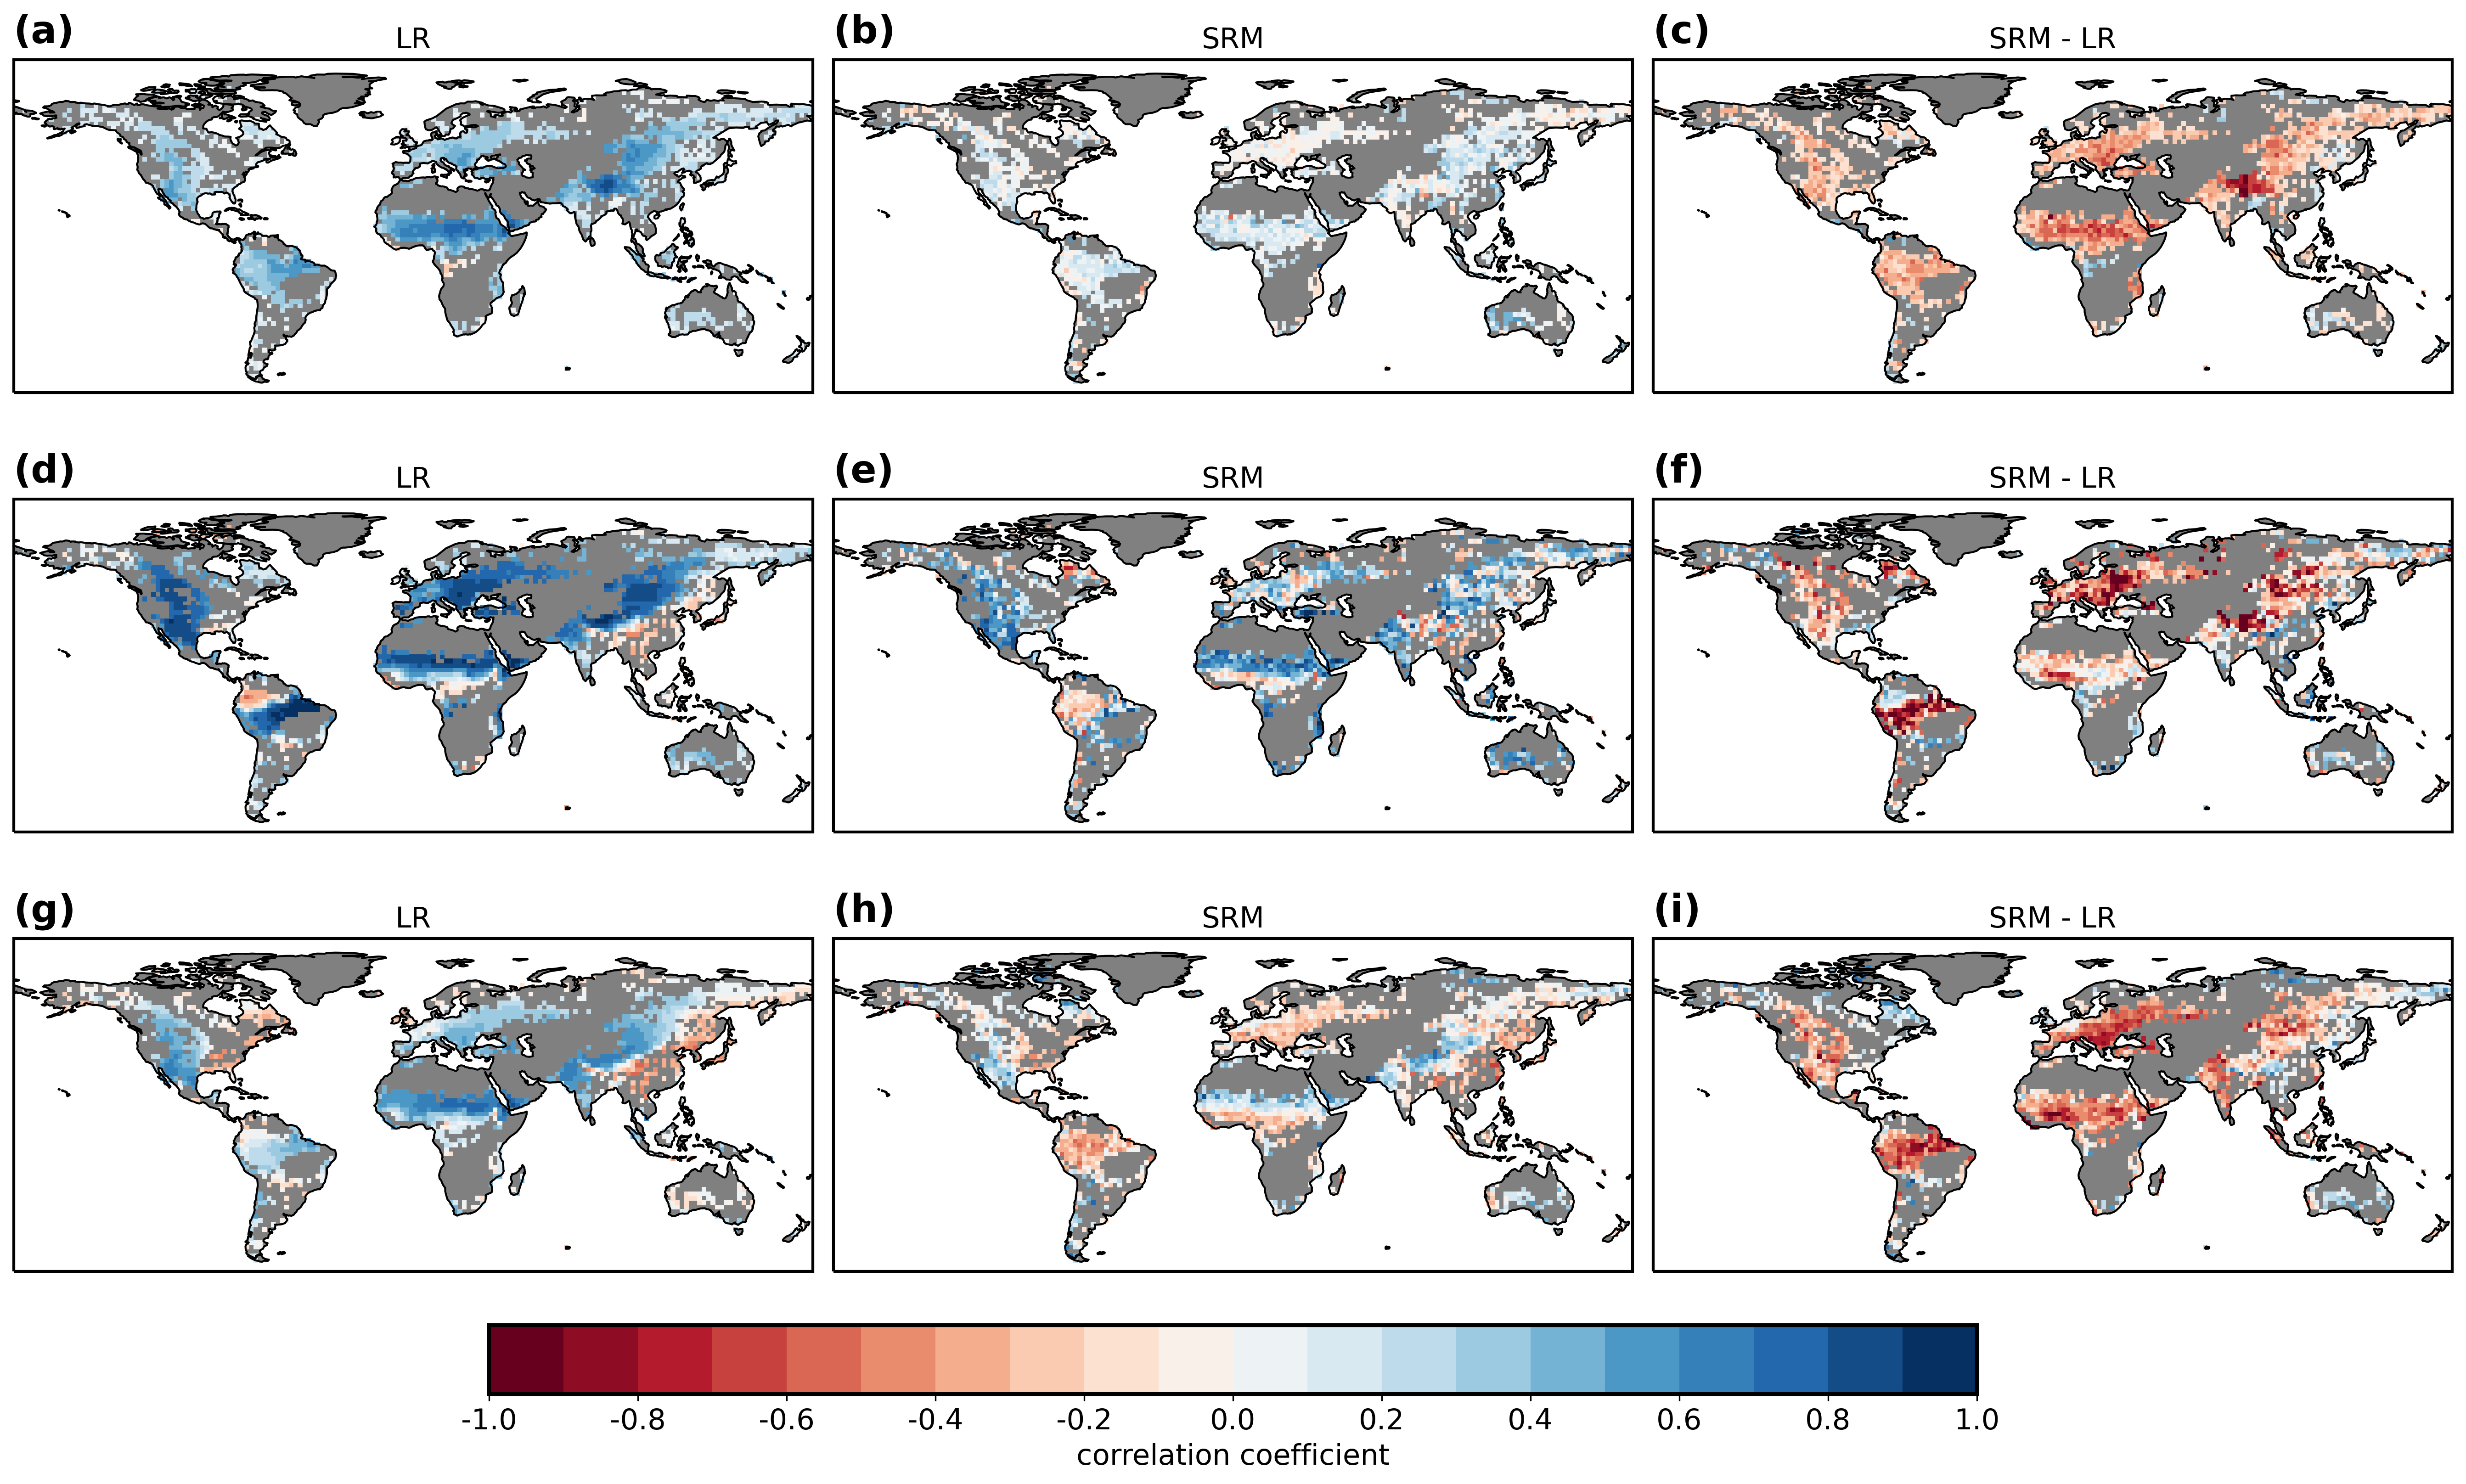

In [21]:
icon_plot1 = icon_corr_pr_smi
cmip_plot1 = internal_pr_smi.mean('time').values
icon_plot2 = icon_corr_lh_smi
cmip_plot2 = internal_lh_smi.mean('time').values
icon_plot3 = icon_corr_lh_pr
cmip_plot3 = internal_lh_pr.mean('time').values

icon_plot1 = icon_plot1 +box_xr-box_xr
cmip_plot1 = cmip_plot1 +box_xr-box_xr
diff_plot1 = icon_plot1-cmip_plot1
icon_plot2 = icon_plot2 +box_xr-box_xr
cmip_plot2 = cmip_plot2 +box_xr-box_xr
diff_plot2 = icon_plot2-cmip_plot2
icon_plot3 = icon_plot3 +box_xr-box_xr
cmip_plot3 = cmip_plot3 +box_xr-box_xr
diff_plot3 = icon_plot3-cmip_plot3

txt_x, txt_y = 0.0, 1.05

rmax, cmax = 3, 3
fig, ax = plt.subplots(nrows=rmax,ncols=cmax, figsize=(18,10), subplot_kw={'projection': ccrs.PlateCarree()},)
matplotlib.rcParams['axes.linewidth'] = 2

#### first row #######
rr = 0
cc = 0
ax[rr,cc].set_extent(box, crs=ccrs.PlateCarree())
ax[rr,cc].coastlines(resolution='110m', color='k')
ax[rr,cc].add_feature(cartopy.feature.LAND, facecolor='grey')
img = ax[rr,cc].pcolor(CMIP_lon,CMIP_lat,cmip_plot1,transform=ccrs.PlateCarree(),edgecolors='None',
                       cmap=cmap_d, vmin = -1.,vmax = 1.,)
ax[rr,cc].set_title('LR', fontsize=15)
ax[rr,cc].text(txt_x, txt_y, '(a)', transform=ax[rr,cc].transAxes, size=20, weight='bold')

cc = 1
ax[rr,cc].set_extent(box, crs=ccrs.PlateCarree())
ax[rr,cc].coastlines(resolution='110m', color='k')
ax[rr,cc].add_feature(cartopy.feature.LAND, facecolor='grey')
img = ax[rr,cc].pcolor(CMIP_lon,CMIP_lat,icon_plot1,transform=ccrs.PlateCarree(),edgecolors='None',
                       cmap=cmap_d, vmin = -1.,vmax = 1.,)
ax[rr,cc].set_title('SRM', fontsize=15)
ax[rr,cc].text(txt_x, txt_y, '(b)', transform=ax[rr,cc].transAxes, size=20, weight='bold')

cc = 2
vmin, vmax = -1., 1.
ax[rr,cc].set_extent(box, crs=ccrs.PlateCarree())
ax[rr,cc].coastlines(resolution='110m', color='k')
ax[rr,cc].add_feature(cartopy.feature.LAND, facecolor='grey')
img = ax[rr,cc].pcolor(CMIP_lon,CMIP_lat, diff_plot1,transform=ccrs.PlateCarree(),edgecolors='None',
                          cmap = cmap_d,vmin=vmin,vmax=vmax,)
ax[rr,cc].set_title('SRM - LR', fontsize=15)
ax[rr,cc].text(txt_x, txt_y, '(c)', transform=ax[rr,cc].transAxes, size=20, weight='bold')


#### second row #######
rr = 1
cc = 0
ax[rr,cc].set_extent(box, crs=ccrs.PlateCarree())
ax[rr,cc].coastlines(resolution='110m', color='k')
ax[rr,cc].add_feature(cartopy.feature.LAND, facecolor='grey')
img = ax[rr,cc].pcolor(CMIP_lon,CMIP_lat,cmip_plot2,transform=ccrs.PlateCarree(),edgecolors='None',
                       cmap=cmap_d, vmin = -1.,vmax = 1.,)
ax[rr,cc].set_title('LR', fontsize=15)
ax[rr,cc].text(txt_x, txt_y, '(d)', transform=ax[rr,cc].transAxes, size=20, weight='bold')

cc = 1
ax[rr,cc].set_extent(box, crs=ccrs.PlateCarree())
ax[rr,cc].coastlines(resolution='110m', color='k')
ax[rr,cc].add_feature(cartopy.feature.LAND, facecolor='grey')
img = ax[rr,cc].pcolor(CMIP_lon,CMIP_lat,icon_plot2,transform=ccrs.PlateCarree(),edgecolors='None',
                       cmap=cmap_d, vmin = -1.,vmax = 1.,)
ax[rr,cc].set_title('SRM', fontsize=15)
ax[rr,cc].text(txt_x, txt_y, '(e)', transform=ax[rr,cc].transAxes, size=20, weight='bold')

cc = 2
vmin, vmax = -1., 1.
ax[rr,cc].set_extent(box, crs=ccrs.PlateCarree())
ax[rr,cc].coastlines(resolution='110m', color='k')
ax[rr,cc].add_feature(cartopy.feature.LAND, facecolor='grey')
img = ax[rr,cc].pcolor(CMIP_lon,CMIP_lat, diff_plot2,transform=ccrs.PlateCarree(),edgecolors='None',
                          cmap = cmap_d,vmin=vmin,vmax=vmax,)
ax[rr,cc].set_title('SRM - LR', fontsize=15)
ax[rr,cc].text(txt_x, txt_y, '(f)', transform=ax[rr,cc].transAxes, size=20, weight='bold')


#### third row #######
rr = 2
cc = 0
ax[rr,cc].set_extent(box, crs=ccrs.PlateCarree())
ax[rr,cc].coastlines(resolution='110m', color='k')
ax[rr,cc].add_feature(cartopy.feature.LAND, facecolor='grey')
img = ax[rr,cc].pcolor(CMIP_lon,CMIP_lat,cmip_plot3,transform=ccrs.PlateCarree(),edgecolors='None',
                       cmap=cmap_d, vmin = -1.,vmax = 1.,)
ax[rr,cc].set_title('LR', fontsize=15)
ax[rr,cc].text(txt_x, txt_y, '(g)', transform=ax[rr,cc].transAxes, size=20, weight='bold')

cc = 1
ax[rr,cc].set_extent(box, crs=ccrs.PlateCarree())
ax[rr,cc].coastlines(resolution='110m', color='k')
ax[rr,cc].add_feature(cartopy.feature.LAND, facecolor='grey')
img = ax[rr,cc].pcolor(CMIP_lon,CMIP_lat,icon_plot3,transform=ccrs.PlateCarree(),edgecolors='None',
                       cmap=cmap_d, vmin = -1.,vmax = 1.,)
ax[rr,cc].set_title('SRM', fontsize=15)
ax[rr,cc].text(txt_x, txt_y, '(h)', transform=ax[rr,cc].transAxes, size=20, weight='bold')

cc = 2
vmin, vmax = -1., 1.
ax[rr,cc].set_extent(box, crs=ccrs.PlateCarree())
ax[rr,cc].coastlines(resolution='110m', color='k')
ax[rr,cc].add_feature(cartopy.feature.LAND, facecolor='grey')
img = ax[rr,cc].pcolor(CMIP_lon,CMIP_lat, diff_plot3,transform=ccrs.PlateCarree(),edgecolors='None',
                          cmap = cmap_d,vmin=vmin,vmax=vmax,)
ax[rr,cc].set_title('SRM - LR', fontsize=15)
ax[rr,cc].text(txt_x, txt_y, '(i)', transform=ax[rr,cc].transAxes, size=20, weight='bold')


cax = fig.add_axes([0.2, -0.03, 0.6, 0.05])
cbar = plt.colorbar(img, orientation='horizontal', fraction=0.050, pad=0.15, ax=ax[:,:], cax=cax)
cbar.set_ticks([-1.0,-0.8,-0.6,-0.4,-0.2,0.0,0.2,0.4,0.6,0.8,1.0])
cbar.set_ticklabels([-1.0,-0.8,-0.6,-0.4,-0.2,0.0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
cbar.set_label('correlation coefficient', fontsize=15)


plt.tight_layout()